
# UTAUT3D — Python CFA/SEM Replication (Colab-ready)

This notebook reproduces the **UTAUT3D** measurement and key hypothesis tests (H3, H4) in Python. It supports three data-input options:
1) **Upload a file** (Excel) when running in Colab  
2) **Google Drive path or file ID** (auto-mounts Drive in Colab)  
3) **Local path** (if running locally)

Outputs:
- Scale composites & reliability (Cronbach’s alpha)
- KMO & Bartlett tests for factorability
- CFA (if `semopy` is available; will auto-install on Colab)
- Moderated regressions for H3 (EE×SRM) and H4 (ATUT×Industry) with controls
- Clean Matplotlib plots
- Exported Excel workbook with all tables


In [1]:

# If running on Google Colab, install missing packages.
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    pass

# Safe installs on Colab only
if IN_COLAB:
    try:
        import semopy  # noqa: F401
    except Exception:
        !pip -q install semopy==2.3.10

    try:
        import openpyxl  # noqa: F401
    except Exception:
        !pip -q install openpyxl

# Common imports
import io, re, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional CFA
try:
    from semopy import Model, calc_stats
    SEMOPY_AVAILABLE = True
except Exception as e:
    SEMOPY_AVAILABLE = False

from numpy.linalg import inv, slogdet
from scipy.stats import chi2 as chi2dist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 5.7 MB/s eta 0:00:00



## 1) Choose your input method

- Set `INPUT_METHOD` to one of: `"upload"`, `"gdrive"`, or `"local"`.
- For Google Drive: provide either a **full path** (e.g., `/content/drive/MyDrive/folder/UTAUT3D ANALYSIS Data.xlsx`) or a **file ID**.
- For local: provide a local filesystem path.


In [2]:

INPUT_METHOD = "upload"   # "upload" | "gdrive" | "local"
LOCAL_OR_DRIVE_PATH_OR_ID = ""  # e.g., '/content/drive/MyDrive/UTAUT3D ANALYSIS Data.xlsx' OR a file ID
SHEET_NAME = None          # None = autodetect first sheet with >=20 cols, or set a specific sheet name/string


In [3]:

# Resolve the Excel file based on the chosen input method.
import os

def resolve_excel_path():
    if INPUT_METHOD == "upload":
        if not IN_COLAB:
            raise RuntimeError("Upload method only works in Google Colab. Use gdrive or local instead.")
        from google.colab import files
        print("Please upload the Excel file (e.g., 'UTAUT3D ANALYSIS Data.xlsx')...")
        up = files.upload()  # user selects file
        if not up:
            raise RuntimeError("No file uploaded.")
        fname = list(up.keys())[0]
        return fname

    elif INPUT_METHOD == "gdrive":
        if not IN_COLAB:
            raise RuntimeError("Google Drive option only works in Colab.")
        from google.colab import drive
        drive.mount('/content/drive')
        s = LOCAL_OR_DRIVE_PATH_OR_ID.strip()
        if not s:
            raise RuntimeError("Provide a Drive path or file ID in LOCAL_OR_DRIVE_PATH_OR_ID.")
        if os.path.exists(s):
            return s
        # Try treating it as a file id
        try:
            import gdown
        except Exception:
            !pip -q install gdown
            import gdown
        out = "/content/utaut3d_input.xlsx"
        if "drive.google.com" in s:
            # gdown can handle full share links
            gdown.download(s, out, quiet=False)
        else:
            # assume it's a bare file id
            gdown.download(id=s, output=out, quiet=False)
        if not os.path.exists(out):
            raise RuntimeError("Could not download file from the provided Drive link or ID.")
        return out

    elif INPUT_METHOD == "local":
        s = LOCAL_OR_DRIVE_PATH_OR_ID.strip()
        if not s or not os.path.exists(s):
            raise RuntimeError("Provide a valid local path in LOCAL_OR_DRIVE_PATH_OR_ID.")
        return s

    else:
        raise ValueError("INPUT_METHOD must be one of: 'upload', 'gdrive', or 'local'.")

excel_path = resolve_excel_path()
print("Excel found at:", excel_path)


Please upload the Excel file (e.g., 'UTAUT3D ANALYSIS Data.xlsx')...


Saving UTAUT3D ANALYSIS Data.xlsx to UTAUT3D ANALYSIS Data.xlsx
Excel found at: UTAUT3D ANALYSIS Data.xlsx



## 2) Load the data
This tries to pick the first sheet with ≥ 20 columns if `SHEET_NAME` is not specified.


In [4]:

xlsx = pd.ExcelFile(excel_path)
if SHEET_NAME is None:
    selected_sheet = None
    for sn in xlsx.sheet_names:
        tmp = pd.read_excel(excel_path, sheet_name=sn)
        if tmp.shape[1] >= 20:
            selected_sheet = sn
            break
    if selected_sheet is None:
        selected_sheet = xlsx.sheet_names[0]
else:
    selected_sheet = SHEET_NAME

df = pd.read_excel(excel_path, sheet_name=selected_sheet)
df.columns = [str(c).strip().replace("\n"," ").replace("\r"," ") for c in df.columns]
print("Loaded sheet:", selected_sheet)
print("Columns (first 60):", df.columns[:60].tolist())


Loaded sheet: UTAUT3D ANALYSIS Data
Columns (first 60): ['Durationinseconds', 'FI', 'AG', '@GE', 'OC2', 'TC1', 'PE', 'EE', 'AT', 'SE', 'BI', 'CF', 'U6', 'RA1', 'RA5', 'OE7', 'EOU3', 'EOU5', 'EOU6', 'EU4', 'A1', 'AF1', 'AF2', 'AF3', 'SE1', 'SE4', 'SE6', 'SE7', 'BI1', 'BI2', 'BI3', 'UB1', 'UB2ED', 'UB2PP', 'UB2TM', 'UB2H0', 'UB2RD', 'UB2TOT', 'UBYN', 'UB3', 'CF1', 'CF2', 'CF3', 'CF4', 'CF5', 'SR1', 'SR2', 'SR3', 'SR4', 'SR5', 'SR6', 'SR7', 'SR8', 'SRM']



## 3) Construct definitions (items → scales)

- PE: U6, RA1, RA5, OE7  
- EE: EOU5, EOU6, EU4  (**EOU3 excluded**)  
- ATUT: A1, AF1, AF2, AF3  
- SE: **SE4, SE6, SE7** (matching manuscript reliability)  
- BI: BI1, BI2, BI3  
- CF: CF1–CF5 (educators only, but used as a factor in CFA/EFA)

Moderators / controls:  
- SRM (spatial rotations mean 0..8; if SR1..SR8 present we compute it)  
- Age: column `AG` (numeric)  
- Gender: `@GE` coded 1=Male, 2=Female → recoded to 1/0  
- Industry: `FI` ***mapped to*** Education=0, Manufacturing=1


In [5]:

items = {
    "PE":  ["U6","RA1","RA5","OE7"],
    "EE":  ["EOU5","EOU6","EU4"],
    "ATUT":["A1","AF1","AF2","AF3"],
    "SE":  ["SE4","SE6","SE7"],   # trio that matches alpha ~.83
    "BI":  ["BI1","BI2","BI3"],
    "CF":  ["CF1","CF2","CF3","CF4","CF5"],
}

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def comp_mean(frame, cols):
    return frame[cols].apply(to_num).mean(axis=1, skipna=True)

# Build SRM if needed
if "SRM" in df.columns:
    srm = to_num(df["SRM"])
else:
    sr_items = [c for c in ["SR1","SR2","SR3","SR4","SR5","SR6","SR7","SR8"] if c in df.columns]
    if len(sr_items) >= 3:
        srm = df[sr_items].apply(to_num).mean(axis=1, skipna=True) * len(sr_items)
    else:
        srm = pd.Series(np.nan, index=df.index)

scales = pd.DataFrame({
    "PE":   comp_mean(df, items["PE"]),
    "EE":   comp_mean(df, items["EE"]),
    "ATUT": comp_mean(df, items["ATUT"]),
    "SE":   comp_mean(df, items["SE"]),
    "BI":   comp_mean(df, items["BI"]),
    "CF":   comp_mean(df, items["CF"]),
    "SRM":  srm,
    "Age":  to_num(df.get("AG", np.nan)),
})

# Gender: @GE 1=Male, 2=Female -> 1/0
scales["Gender"] = to_num(df.get("@GE", np.nan)).map({1:1.0, 2:0.0})

# Industry mapping: in the provided data 1/2 map best as Education=0, Manufacturing=1
scales["Industry"] = to_num(df.get("FI", np.nan)).map({1:0.0, 2:1.0})

scales.head()


,PE,EE,ATUT,SE,BI,CF,SRM,Age,Gender,Industry
0,4.25,4.333333,5.00,4.333333,5.0,6.0,8,39,1.0,0.0
1,3.75,4.000000,4.75,4.333333,5.0,5.0,4,31,1.0,1.0
2,5.00,5.000000,5.00,5.000000,5.0,4.8,1,45,1.0,0.0
3,4.00,5.000000,3.75,1.666667,5.0,6.0,6,43,1.0,0.0
4,3.75,4.000000,4.75,4.000000,5.0,6.0,1,29,1.0,0.0



## 4) Reliability (Cronbach’s alpha)


In [6]:

def cronbach_alpha(df_sub):
    arr = df_sub.apply(to_num).dropna().values
    if arr.ndim != 2 or arr.shape[0] < 5 or arr.shape[1] < 2:
        return np.nan
    k = arr.shape[1]
    item_vars = arr.var(axis=0, ddof=1)
    total_var = arr.sum(axis=1).var(ddof=1)
    if total_var <= 1e-12:
        return np.nan
    return float((k/(k-1.0))*(1.0 - item_vars.sum()/total_var))

rel = []
for k, cols in items.items():
    rel.append({"Scale": k, "k_items": len(cols),
                "Alpha": cronbach_alpha(df[cols]),
                "Items": ", ".join(cols)})
reliability_df = pd.DataFrame(rel).sort_values("Scale")
reliability_df


,Scale,k_items,Alpha,Items
2,ATUT,4,0.861554,"A1, AF1, AF2, AF3"
4,BI,3,0.973912,"BI1, BI2, BI3"
5,CF,5,0.915730,"CF1, CF2, CF3, CF4, CF5"
1,EE,3,0.890034,"EOU5, EOU6, EU4"
0,PE,4,0.846854,"U6, RA1, RA5, OE7"
3,SE,3,0.832327,"SE4, SE6, SE7"



## 5) Factorability: KMO & Bartlett’s test (23 indicators; EOU3 dropped)


In [7]:

items_23 = ["U6","RA1","RA5","OE7",
            "EOU5","EOU6","EU4",
            "A1","AF1","AF2","AF3",
            "SE4","SE6","SE7",
            "BI1","BI2","BI3",
            "CF1","CF2","CF3","CF4","CF5"]

X = df[items_23].apply(to_num).dropna()
n, p = X.shape
R = np.corrcoef(X, rowvar=False)
sign, logdet = slogdet(R)
chi2 = -(n - 1 - (2*p + 5)/6) * logdet
df_bart = p*(p-1)/2
bart_p = chi2dist.sf(chi2, df=df_bart)

Ri = inv(R)
D = np.diag(1/np.sqrt(np.diag(Ri)))
PC = -D @ Ri @ D
np.fill_diagonal(PC, 0)
r2 = R**2; np.fill_diagonal(r2, 0)
pc2 = PC**2; np.fill_diagonal(pc2, 0)
kmo = r2.sum() / (r2.sum() + pc2.sum())

kmo_bart = pd.DataFrame([
    {"Metric":"Bartlett_chi2","Value":float(chi2)},
    {"Metric":"Bartlett_df","Value":int(df_bart)},
    {"Metric":"Bartlett_p","Value":float(bart_p)},
    {"Metric":"KMO_overall","Value":float(kmo)},
    {"Metric":"N_used","Value":int(n)}
])
kmo_bart


,Metric,Value
0,Bartlett_chi2,1.267116e+03
1,Bartlett_df,2.310000e+02
2,Bartlett_p,2.017813e-142
3,KMO_overall,8.406331e-01
4,N_used,6.500000e+01



## 6) Confirmatory Factor Analysis (CFA) with `semopy` (if available)

Latent structure (first-indicator scaled by default):


In [9]:
print("SEMOPY_AVAILABLE:", SEMOPY_AVAILABLE)

if SEMOPY_AVAILABLE:
    model_desc = "\n".join([
        "PE =~ "   + " + ".join(items["PE"]),
        "EE =~ "   + " + ".join(items["EE"]),
        "ATUT =~ " + " + ".join(items["ATUT"]),
        "SE =~ "   + " + ".join(items["SE"]),
        "BI =~ "   + " + ".join(items["BI"]),
        "CF =~ "   + " + ".join(items["CF"]),
    ])
    obs = [c for v in items.values() for c in v]
    Xc = df[obs].apply(to_num).dropna()
    mod = Model(model_desc)
    mod.fit(Xc)
    st = calc_stats(mod)
    fit_keys = ["CFI","TLI","RMSEA","SRMR","Chi-Squared","DoF"]
    fit = {k: st.get(k, None) for k in fit_keys}
    loadings = mod.inspect(std_est=True)
    display(pd.Series(fit, name="Fit_Indices"))
    display(loadings.head(20))
else:
    print("semopy not available here. On Colab, it'll install automatically (rerun the cell).")

SEMOPY_AVAILABLE: True


,Fit_Indices
CFI,"Value 0.917188 Name: CFI, dtype: float64"
TLI,"Value 0.901394 Name: TLI, dtype: float64"
RMSEA,"Value 0.091095 Name: RMSEA, dtype: float64"
SRMR,None
Chi-Squared,None
DoF,"Value 194 Name: DoF, dtype: int64"


,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,U6,~,PE,1.000000,0.844718,-,-,-
1,RA1,~,PE,1.106468,0.892941,0.12019,9.205966,0.0
2,RA5,~,PE,1.160808,0.897141,0.125237,9.268916,0.0
3,OE7,~,PE,0.585588,0.445330,0.159844,3.663502,0.000249
4,EOU5,~,EE,1.000000,0.869709,-,-,-
5,EOU6,~,EE,1.141698,0.904326,0.112862,10.115902,0.0
6,EU4,~,EE,1.205149,0.915064,0.116936,10.306037,0.0
7,A1,~,ATUT,1.000000,0.786576,-,-,-
8,AF1,~,ATUT,1.120339,0.753911,0.169319,6.616749,0.0
9,AF2,~,ATUT,1.522886,0.951246,0.174219,8.741236,0.0



## 7) Hypothesis tests (OLS): H3 and H4

- **H3**: `BI ~ EE + SRM + EE×SRM + Age + Gender`  
- **H4**: `BI ~ ATUT + Industry + ATUT×Industry + Age + Gender`

(Continuous predictors are mean-centered.)


In [10]:

work = scales.copy()

for c in ["EE","ATUT","SRM","Age"]:
    work[c+"_c"] = work[c] - work[c].mean(skipna=True)

work["EExSRM"] = work["EE_c"] * work["SRM_c"]
work["ATUTxInd"] = work["ATUT_c"] * work["Industry"]

h3 = smf.ols("BI ~ EE_c + SRM_c + EExSRM + Age_c + Gender", data=work.dropna()).fit()
h4 = smf.ols("BI ~ ATUT_c + Industry + ATUTxInd + Age_c + Gender", data=work.dropna()).fit()

def compact(res):
    return pd.Series({
        "R_squared":res.rsquared,
        "Adj_R_squared":res.rsquared_adj,
        "F":float(res.fvalue),
        "F_p":float(res.f_pvalue),
        "N":int(res.nobs)
    })

display(compact(h3).to_frame("H3_Summary"))
display(h3.params.to_frame("coef").assign(std_err=h3.bse, t=h3.tvalues, p=h3.pvalues))

display(compact(h4).to_frame("H4_Summary"))
display(h4.params.to_frame("coef").assign(std_err=h4.bse, t=h4.tvalues, p=h4.pvalues))


,H3_Summary
R_squared,4.471069e-01
Adj_R_squared,4.226426e-01
F,1.827590e+01
F_p,2.933960e-13
N,1.190000e+02


,coef,std_err,t,p
Intercept,3.421424,0.155313,22.029228,1.053333e-42
EE_c,0.647682,0.116611,5.554223,1.875035e-07
SRM_c,0.012358,0.037627,0.328447,7.431818e-01
EExSRM,0.109401,0.046147,2.370691,1.944817e-02
Age_c,0.009728,0.006483,1.500499,1.362741e-01
Gender,0.883160,0.203933,4.330629,3.232982e-05


,H4_Summary
R_squared,5.098695e-01
Adj_R_squared,4.881823e-01
F,2.351017e+01
F_p,3.920350e-16
N,1.190000e+02


,coef,std_err,t,p
Intercept,4.154566,0.218737,18.993453,5.791238e-37
ATUT_c,0.212715,0.212936,0.998964,3.199464e-01
Industry,-0.982836,0.199624,-4.923445,2.924180e-06
ATUTxInd,0.863343,0.279112,3.093180,2.495433e-03
Age_c,0.010016,0.006102,1.641529,1.034680e-01
Gender,0.555065,0.212403,2.613266,1.018859e-02



## 8) Plots

Simple distribution checks and interaction visualizations (one chart per cell).


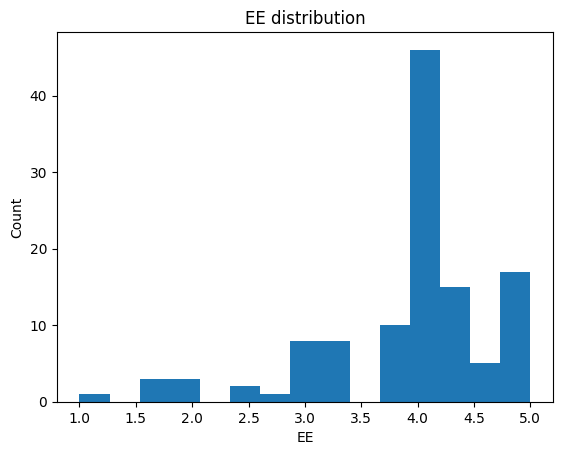

In [11]:

# Histograms of key composites
fig, ax = plt.subplots()
ax.hist(work["EE"].dropna(), bins=15)
ax.set_title("EE distribution")
ax.set_xlabel("EE")
ax.set_ylabel("Count")
plt.show()


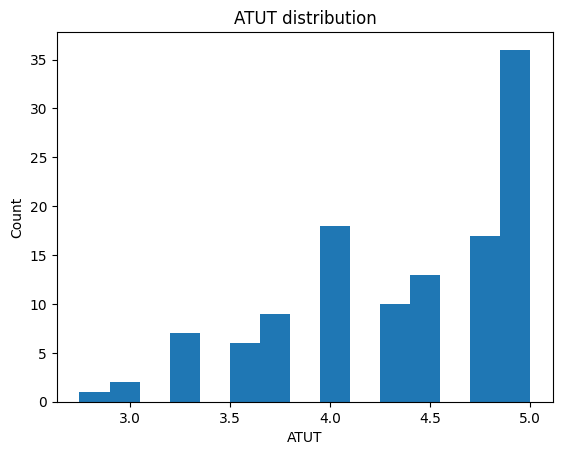

In [12]:

fig, ax = plt.subplots()
ax.hist(work["ATUT"].dropna(), bins=15)
ax.set_title("ATUT distribution")
ax.set_xlabel("ATUT")
ax.set_ylabel("Count")
plt.show()


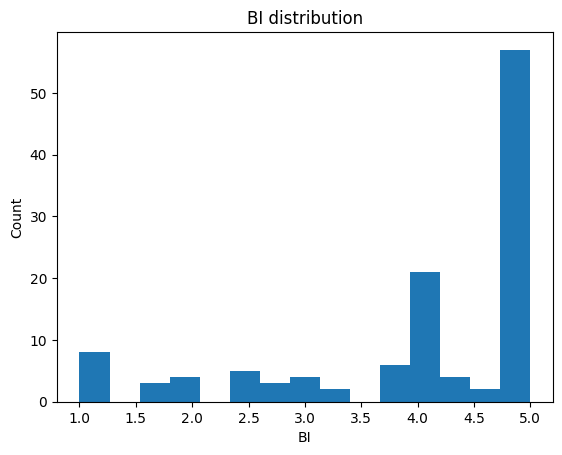

In [13]:

fig, ax = plt.subplots()
ax.hist(work["BI"].dropna(), bins=15)
ax.set_title("BI distribution")
ax.set_xlabel("BI")
ax.set_ylabel("Count")
plt.show()


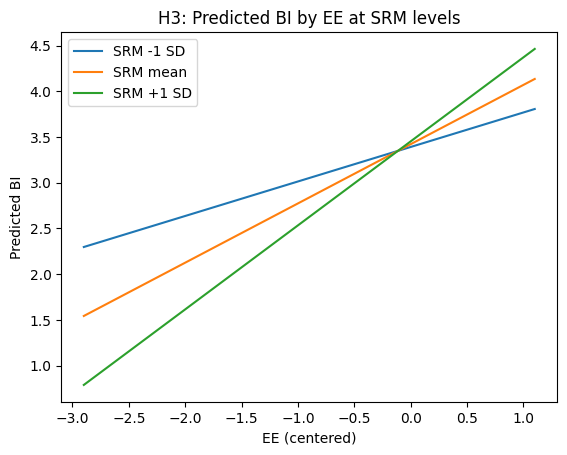

In [14]:

# H3: Simple slopes of EE at SRM +/- 1 SD
EEc = work["EE_c"]
SRMc = work["SRM_c"]
Agec = work["Age_c"].fillna(0)
Gender = work["Gender"].fillna(0)
df_plot = pd.DataFrame({"EE_c":EEc, "SRM_c":SRMc, "Age_c":Agec, "Gender":Gender})
low = SRMc.mean() - SRMc.std()
high = SRMc.mean() + SRMc.std()

xgrid = np.linspace(EEc.min(), EEc.max(), 50)
def yhat(ee, srm):
    return h3.params["Intercept"] + h3.params["EE_c"]*ee + h3.params["SRM_c"]*srm + h3.params["EExSRM"]*ee*srm

fig, ax = plt.subplots()
ax.plot(xgrid, [yhat(x, low) for x in xgrid], label="SRM -1 SD")
ax.plot(xgrid, [yhat(x, 0.0) for x in xgrid], label="SRM mean")
ax.plot(xgrid, [yhat(x, high) for x in xgrid], label="SRM +1 SD")
ax.set_title("H3: Predicted BI by EE at SRM levels")
ax.set_xlabel("EE (centered)")
ax.set_ylabel("Predicted BI")
ax.legend()
plt.show()


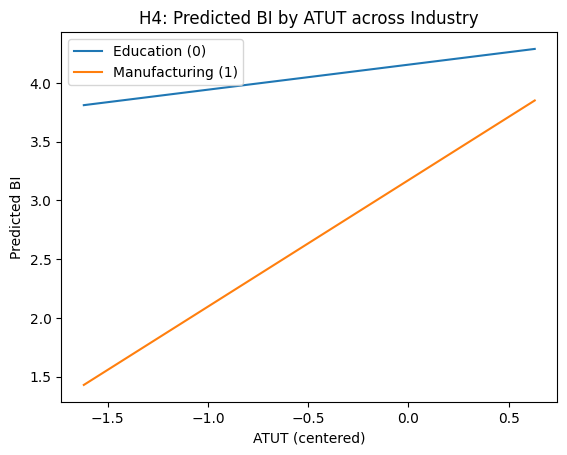

In [15]:

# H4: Simple slopes of ATUT by Industry (0=Education, 1=Manufacturing)
ATUTc = work["ATUT_c"]
Ind = work["Industry"].fillna(0)

xgrid = np.linspace(ATUTc.min(), ATUTc.max(), 50)
def yhat_h4(atut, ind):
    return (h4.params["Intercept"] + h4.params["ATUT_c"]*atut +
            h4.params["Industry"]*ind + h4.params["ATUTxInd"]*atut*ind)

fig, ax = plt.subplots()
ax.plot(xgrid, [yhat_h4(x, 0.0) for x in xgrid], label="Education (0)")
ax.plot(xgrid, [yhat_h4(x, 1.0) for x in xgrid], label="Manufacturing (1)")
ax.set_title("H4: Predicted BI by ATUT across Industry")
ax.set_xlabel("ATUT (centered)")
ax.set_ylabel("Predicted BI")
ax.legend()
plt.show()



## 9) Export all key outputs to Excel


In [18]:

out_path = "UTAUT3D_Python_CFA_SEM_Results.xlsx"

# Prepare tables
h3_summ = pd.DataFrame([{
    "R_squared": h3.rsquared, "Adj_R_squared": h3.rsquared_adj,
    "F": float(h3.fvalue), "F_p": float(h3.f_pvalue), "N": int(h3.nobs)
}])
h4_summ = pd.DataFrame([{
    "R_squared": h4.rsquared, "Adj_R_squared": h4.rsquared_adj,
    "F": float(h4.fvalue), "F_p": float(h4.f_pvalue), "N": int(h4.nobs)
}])

with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
    reliability_df.to_excel(writer, sheet_name="Reliability", index=False)
    scales.to_excel(writer, sheet_name="Scale_Composites", index=False)
    h3_summ.to_excel(writer, sheet_name="H3_Summary", index=False)
    h3.params.to_frame("coef").assign(std_err=h3.bse, t=h3.tvalues, p=h3.pvalues)        .reset_index().rename(columns={"index":"term"})        .to_excel(writer, sheet_name="H3_Coefs", index=False)
    h4_summ.to_excel(writer, sheet_name="H4_Summary", index=False)
    h4.params.to_frame("coef").assign(std_err=h4.bse, t=h4.tvalues, p=h4.pvalues)        .reset_index().rename(columns={"index":"term"})        .to_excel(writer, sheet_name="H4_Coefs", index=False)
    kmo_bart.to_excel(writer, sheet_name="KMO_Bartlett", index=False)

print("Wrote:", out_path)


Wrote: UTAUT3D_Python_CFA_SEM_Results.xlsx


In [17]:
# Install xlsxwriter if not available and running on Colab
if IN_COLAB:
    try:
        import xlsxwriter # noqa: F401
    except Exception:
        !pip -q install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 6.0 MB/s eta 0:00:00
